# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [ ]:
# for linux
# %sudo apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# %brew install poppler tesseract libmagic

In [3]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [1]:
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = output_path + '2021-3-12-Handout-Med-Student.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

/nas-data/alim_workspace/deepseek/rag_pdf/envrag_langchain/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [3]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [4]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '8fa31f78-44bd-4e51-9b16-0df38008bccb',
 'text': '®',
 'metadata': {'coordinates': {'points': ((179.86111111111111,
     1769.3994730555553),
    (179.86111111111111, 1791.249428611111),
    (199.72222222222223, 1791.249428611111),
    (199.72222222222223, 1769.3994730555553)),
   'system': 'PixelSpace',
   'layout_width': 1653,
   'layout_height': 2339},
  'last_modified': '2025-04-06T22:55:26',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 3,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAAWABQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8j

### Separate extracted elements into tables, text, and images

In [5]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [6]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

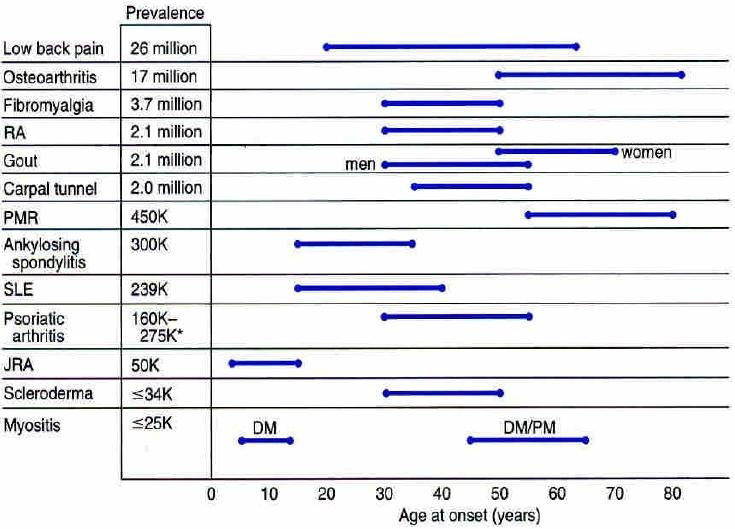

In [8]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [9]:
%pip install -Uq langchain-groq


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
from langchain_community.chat_models import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}
"""

prompt = ChatPromptTemplate.from_template(prompt_text)

# Gunakan model lokal Ollama (pastikan sudah di-pull, misalnya: mistral, gemma3, deepseek-medical)
model = ChatOllama(model="llama3", temperature=0.5)

# Build chain
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# Ringkas teks
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Ringkas tabel
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})


In [12]:
# from langchain_groq import ChatGroq
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.output_parsers import StrOutputParser

In [11]:
# # Prompt
# prompt_text = """
# You are an assistant tasked with summarizing tables and text.
# Give a concise summary of the table or text.

# Respond only with the summary, no additionnal comment.
# Do not start your message by saying "Here is a summary" or anything like that.
# Just give the summary as it is.

# Table or text chunk: {element}

# """
# prompt = ChatPromptTemplate.from_template(prompt_text)

# # Summary chain
# model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
# summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [10]:
# # Summarize text
# text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# # Summarize tables
# tables_html = [table.metadata.text_as_html for table in tables]
# table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [12]:
text_summaries

['The clinical approach to rheumatic patients involves recognizing "Red Flag" symptoms and signs, such as infection, acute crystal-induced arthritis, systemic vasculitis, acute myelopathy, and fracture. The initial approach includes thorough history taking and physical examination to determine whether the musculoskeletal complaint is articular or non-articular, inflammatory or non-inflammatory, acute or chronic, and localized or widespread.',
 'Low back pain affects 26 million people, followed by osteoarthritis (17 million), fibromyalgia (3.7 million), and rheumatoid arthritis (2.1 million). Other prevalent conditions include gout, carpal tunnel syndrome, and psoriatic arthritis. Factors that contribute to the development of these conditions include age, gender, history of infection, past systemic diseases, family history, and other important factors such as smoking and alcohol intake. The onset and evolution of these conditions can be abrupt, indolent, acute, chronic, or migratory, wi

### Image summaries

We will use llava7bto produce the image summaries.

In [15]:
# import base64
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama

prompt_text = """
Describe the image in detail. It is part of a document explaining The Clinical Approach to Rheumatic Patients.
Be specific about charts, plots, or text visible.

Image (base64 encoded):
{image}
"""

prompt = ChatPromptTemplate.from_template(prompt_text)

model = ChatOllama(model="llava:7b", temperature=0.3)

chain = {"image": lambda x: x} | prompt | model | StrOutputParser()

image_summaries = chain.batch(images, {"max_concurrency": 6})

for i, summary in enumerate(image_summaries):
    print(f"\n[Image {i+1}]\n{summary}")


[Image 1]
 This image appears to be a digital illustration or graphic. It features a stylized depiction of a person, possibly a child, with a simplistic and somewhat abstract design. The figure has large eyes and a small mouth, and the body is not fully visible, with the limbs appearing to blend into the background. The colors are limited, with shades of blue, green, and yellow dominating the image.

The style of the illustration suggests it may be used for educational purposes or as part of a children's book or game. The simplicity of the design could make it appealing to young audiences. However, without additional context, it is difficult to determine the exact purpose or intent behind this image. 

[Image 2]
 The image is a graph with a title that reads "The Clinical Approach to Rheumatic Patients." There are two lines on the graph, one in blue and one in red. The x-axis of the graph is labeled "Time (months)" and ranges from 0 to 12 months. The y-axis is labeled "Disease Activity

In [18]:
# %pip install -Uq langchain_openai


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from langchain_openai import ChatOpenAI

# prompt_template = """Describe the image in detail. For context,
#                   the image is part of a research paper explaining the transformers
#                   architecture. Be specific about graphs, such as bar plots."""
# messages = [
#     (
#         "user",
#         [
#             {"type": "text", "text": prompt_template},
#             {
#                 "type": "image_url",
#                 "image_url": {"url": "data:image/jpeg;base64,{image}"},
#             },
#         ],
#     )
# ]

# prompt = ChatPromptTemplate.from_messages(messages)

# chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


# image_summaries = chain.batch(images)

In [16]:
image_summaries

[" This image appears to be a digital illustration or graphic. It features a stylized depiction of a person, possibly a child, with a simplistic and somewhat abstract design. The figure has large eyes and a small mouth, and the body is not fully visible, with the limbs appearing to blend into the background. The colors are limited, with shades of blue, green, and yellow dominating the image.\n\nThe style of the illustration suggests it may be used for educational purposes or as part of a children's book or game. The simplicity of the design could make it appealing to young audiences. However, without additional context, it is difficult to determine the exact purpose or intent behind this image. ",
 ' The image is a graph with a title that reads "The Clinical Approach to Rheumatic Patients." There are two lines on the graph, one in blue and one in red. The x-axis of the graph is labeled "Time (months)" and ranges from 0 to 12 months. The y-axis is labeled "Disease Activity Score" and al

In [17]:
print(image_summaries[1])

 The image is a graph with a title that reads "The Clinical Approach to Rheumatic Patients." There are two lines on the graph, one in blue and one in red. The x-axis of the graph is labeled "Time (months)" and ranges from 0 to 12 months. The y-axis is labeled "Disease Activity Score" and also ranges from 0 to 12. There are no visible texts or charts outside of the graph itself. 


## Load data and summaries to vectorstore

### Create the vectorstore

In [18]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Gunakan HF embeddings lokal agar tidak kena rate limit
embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embedding_function)
store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

/tmp/ipykernel_3678245/1330859022.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/nas-data/alim_workspace/deepseek/rag_pdf/envrag_langchain/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/nas-data/alim_workspace/deepseek/rag_pdf/envrag_langchain/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.uti

In [14]:
# import uuid
# from langchain.vectorstores import Chroma
# from langchain.storage import InMemoryStore
# from langchain.schema.document import Document
# from langchain.embeddings import OpenAIEmbeddings
# from langchain.retrievers.multi_vector import MultiVectorRetriever

# # The vectorstore to use to index the child chunks
# vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# # The storage layer for the parent documents
# store = InMemoryStore()
# id_key = "doc_id"

# # The retriever (empty to start)
# retriever = MultiVectorRetriever(
#     vectorstore=vectorstore,
#     docstore=store,
#     id_key=id_key,
# )

/tmp/ipykernel_3660390/278287695.py:9: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())
/tmp/ipykernel_3660390/278287695.py:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())


### Load the summaries and link the to the original data

In [20]:
from langchain_core.documents import Document
import uuid

# Fungsi bantu
def add_to_retriever(items, summaries, retriever, id_key="source"):
    if not items or not summaries:
        print("⚠️  Skip: No data to add.")
        return

    ids = [str(uuid.uuid4()) for _ in items]
    documents = [
        Document(page_content=summary, metadata={id_key: ids[i]})
        for i, summary in enumerate(summaries)
    ]

    try:
        retriever.vectorstore.add_documents(documents)
        retriever.docstore.mset(list(zip(ids, items)))
        print(f"✅ Added {len(items)} items to retriever.")
    except ValueError as e:
        print(f"❌ Error while adding to vectorstore: {e}")

add_to_retriever(texts, text_summaries, retriever)

add_to_retriever(tables, table_summaries, retriever)

add_to_retriever(images, image_summaries, retriever)


✅ Added 85 items to retriever.
⚠️  Skip: No data to add.
✅ Added 149 items to retriever.


In [ ]:
# # Add texts
# doc_ids = [str(uuid.uuid4()) for _ in texts]
# summary_texts = [
#     Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
# ]
# retriever.vectorstore.add_documents(summary_texts)
# retriever.docstore.mset(list(zip(doc_ids, texts)))

# # Add tables
# table_ids = [str(uuid.uuid4()) for _ in tables]
# summary_tables = [
#     Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
# ]
# retriever.vectorstore.add_documents(summary_tables)
# retriever.docstore.mset(list(zip(table_ids, tables)))

# # Add image summaries
# img_ids = [str(uuid.uuid4()) for _ in images]
# summary_img = [
#     Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
# ]
# retriever.vectorstore.add_documents(summary_img)
# retriever.docstore.mset(list(zip(img_ids, images)))

In [21]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import HumanMessage
from base64 import b64decode
from langchain_core.prompts import ChatPromptTemplate

# Parse images vs texts
def parse_docs(docs):
    b64, text = [], []
    for doc in docs:
        try:
            b64decode(doc.page_content)
            b64.append(doc.page_content)
        except:
            text.append(doc)
    return {"images": b64, "texts": text}

# Build multimodal prompt
def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = "\n".join([t.text for t in docs_by_type["texts"]])

    prompt_template = f"""
Answer the question based only on the following context (text, tables, images).

Context:
{context_text}

Question:
{user_question}
"""
    prompt_content = [{"type": "text", "text": prompt_template}]

    for image in docs_by_type["images"]:
        prompt_content.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{image}"},
            }
        )

    return [HumanMessage(content=prompt_content)]

# RAG chain using local model
rag_chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOllama(model="llava:7b", temperature=0.4)
    | StrOutputParser()
)


In [22]:
question = "Explain the diagnosis flow for rheumatic patients."
answer = rag_chain.invoke(question)

print("🔍 Question:", question)
print("\n🧠 Answer:\n", answer)


🔍 Question: Explain the diagnosis flow for rheumatic patients.

🧠 Answer:
  The diagnosis flow for rheumatic patients typically involves a series of steps to determine the underlying cause of their joint pain or other symptoms associated with rheumatic diseases. Here is an overview of the process:

1. Initial assessment: During the initial assessment, the patient's history and physical examination are performed to identify any potential red flags that may require immediate attention or further investigation. This includes assessing for infection, malignancy, or other serious conditions that could be causing the joint pain or other symptoms.
2. Differential diagnosis: Based on the initial assessment, a differential diagnosis is developed, which involves identifying potential causes of the patient's symptoms. This may involve considering various rheumatic diseases, such as osteoarthritis, rheumatoid arthritis (RA), psoriatic arthropathy, spondyloarthropathy, lupus, and others.
3. Laborat

In [27]:
import json

with open("output_rag_summary.json", "w") as f:
    json.dump({
        "image_summaries": image_summaries,
        "text_summaries": [t.page_content for t in summary_texts],
        "table_summaries": [t.page_content for t in summary_tables],
    }, f, indent=2)


## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)